In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
salt = pickle.load(open("salt.pickle","rb"))

In [3]:
salt.shape

(4000, 2, 128, 128)

In [4]:
mask = np.moveaxis(salt, 0, 1)

In [5]:
mask.shape

(2, 4000, 128, 128)

# The labels will now be created in a one-hot fashion

In [6]:
#create zeros or ones
labels = mask[1] / 255

In [7]:
X_train = mask[0] / 255

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [9]:
X_train.shape

(4000, 128, 128, 1)

In [10]:
from keras.models import Sequential

Using TensorFlow backend.


In [11]:
# from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D
# from keras import Model

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [14]:
epochs = 200
batch_size = 32

In [15]:
labels.shape

(4000, 128, 128)

In [16]:
labels = np.expand_dims(labels, axis = 4)

c:\users\ianhu\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


In [17]:
"""""
Note: This model was directly taken(and slightly modified) from Peter Hönigschmid kernel
When I built this model, I learned the "new" way to create a kaggle model, which is interesting
I also learned about the U-Net which gave impressive results in the validation accuracy.  This model
used pooling, dropout, and convolution to get great results
"""""
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer
img_size_target = 128

input_layer = Input((128, 128, 1))
output_layer = build_model(input_layer, 16)

In [18]:
model = Model(input_layer, output_layer)

In [19]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(X_train, labels,
                    epochs=epochs,
                    validation_split = 0.2,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 16s 5ms/step - loss: 0.5636 - acc: 0.7489 - val_loss: 0.4797 - val_acc: 0.7640

Epoch 00001: val_loss improved from inf to 0.47972, saving model to ./keras.model
Epoch 2/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.4838 - acc: 0.7633 - val_loss: 0.4177 - val_acc: 0.8371

Epoch 00002: val_loss improved from 0.47972 to 0.41772, saving model to ./keras.model
Epoch 3/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.4253 - acc: 0.8235 - val_loss: 0.4888 - val_acc: 0.7572

Epoch 00003: val_loss did not improve from 0.41772
Epoch 4/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.3966 - acc: 0.8402 - val_loss: 0.3565 - val_acc: 0.8454

Epoch 00004: val_loss improved from 0.41772 to 0.35654, saving model to ./keras.model
Epoch 5/200
3200/3200 [==============================] - 12s 4ms/step - loss: 0.3628 - acc: 0.8565 -

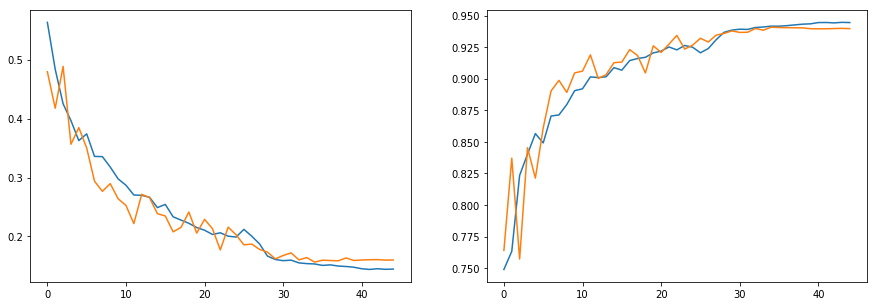

In [21]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")